## Imports

In [58]:
# import modules
from numba import jit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
from scipy.special import erf

In [59]:
cmap = matplotlib.cm.get_cmap('cividis').copy()

colors1 = plt.cm.inferno(np.linspace(0., 1, 128))
colors2 = plt.cm.viridis(np.linspace(0, 1, 106))

# combine them and build a new colormap
colors = np.vstack((colors1[:22:-1], colors2[4:]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors[::-1])

## The plasma profiles

### Proxy for fusion-relevant

In [60]:

def profile(x, y, npt_x, npt_y, ne_peak=1, eps = 1, triang = 0, scale=2):

    x_aux = 4*((x - npt_x / 2)/(10*16*scale)+.1)

    x_profile = (1 + erf((1+triang)*x_aux)) * np.exp(-x_aux)

    return .75* ne_peak* x_profile * np.exp(-((y - npt_y / 2)/(10*16*scale * np.sqrt(2)*eps/4))**2)

### Plasma torch

In [61]:

def old_profile(x, y, npt_x, npt_y, ne_peak, stdev, beta, scale=2):
    aux1 = (x - npt_x / 2) / (np.sqrt(2) * stdev)
    aux2 = (y - npt_y / 2) / (np.sqrt(2) * stdev)
            
    return ne_peak * np.exp(-(aux1 * aux1 + aux2 * aux2))**beta

### Jet-like

In [62]:
from scipy.optimize import root_scalar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def jet(angle, a, R0, delta, kappa):
    R = R0 + a*np.cos(angle + delta*np.sin(angle))
    z = kappa*a*np.sin(angle)

    return R, z

def inverse(R, z, R0, delta, kappa):
    
    def f(x, R=1, z=1, R0=1, delta=1, kappa=1, neg_side=False):
        theta = np.arcsin(z/(kappa*x))
        if neg_side:
            theta = np.pi - theta

        return x*np.cos(theta + delta*z/(kappa*x)) -R +R0

    try:
        a = root_scalar(f, args=(R, z, R0, delta, kappa), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
        #The extra 1e-13 is to avoid the root finding algorithm to get stuck, as arcsin needs an argument between -1 and 1
        return a, np.arcsin(z/(kappa*a))
    
    except ValueError:
        try:
            #print('Were on the negative side')
            a = root_scalar(f, args=(R, z, R0, delta, kappa, True), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
            return a, np.pi - np.arcsin(z/(kappa*a))
    
        except ValueError:
            return 2, np.pi

def jet_profile(a, theta, amplitude=.25, mode_num=4):
    if a>1:
        #This is to avoid the plasma extending beyond the last closed flux surface
        return 0 
    
    elif a< .8:
        #Inside, the density follows the flux surfaces to 1st order
        return np.sqrt(1-a) 
    
    else:
        #between around a=.8 to a=1, we add a perturbation, gaussian in a, sinusoidal in theta
        return np.sqrt(1-a) + amplitude * np.sin(mode_num*theta)* np.exp(-((a-.9)/.04)**2) 
    

def make_density(R, z, R0, ne_peak, delta, kappa, profile=jet_profile, amplitude=.25, mode_num=4):

    grid = np.zeros((len(z), len(R)))
    outer_contour_R, outer_contour_z = jet(np.linspace(0, 2*np.pi, 200), 1, R0, delta, kappa)
    RM, Rm, zM, zm = np.amax(outer_contour_R), np.amin(outer_contour_R), np.amax(outer_contour_z), np.amin(outer_contour_z)

    

    for i, R_val in enumerate(R):
        for j, z_val in enumerate(z):
            if R_val > RM or R_val < Rm or z_val > zM or z_val < zm:
                continue
            else:
                contour_value, theta = inverse(R_val, z_val, R0, delta, kappa)
                grid[j, i] = ne_peak *profile(contour_value, theta, amplitude, mode_num)


    return grid

def transform(angle, a, R0, delta, kappa, scale):
    R2, z2 = jet(angle, a, R0, delta, kappa)
    R2 *= 53.4 * scale #The plasma extends from R=2 to 4, which is from 1/3 to 2/3 of the integration domain. 
    z2 *= 53.4 * scale
    z2 += 160 * scale
    return R2, z2


## Further simulation setup functions

### Antenna for wave excitation

In [63]:
@jit
def make_antenna_profile(npt_y, xs, w0, source, bb):
    
    for y in range(2, npt_y - 1, 2):
        
        aux = (npt_y / 2 - y) / w0
        
        aux1 = 0.75 * np.exp(-aux * aux) * 20 # gaussian envelope
        
        # excite Bz component (odd - odd)
        bb[int(xs + 1), y + 1] += 2 * source * aux1

### Background magnetic field

In [64]:
@jit
def make_B0(npt_x, npt_y, cntrl_para, b0):
    for x in range(0, npt_x - 1, 2):
        for y in range(0, npt_y - 1, 2):
            b0[x + 1, y + 1] = cntrl_para # B0z

### Apply absorbing boundary conditions

In [65]:
@jit
def absorbers(depth, npt_x, npt_y, ee, bb, jj, b0): # depth -> depth of the absorbing region
    # absorbers on the left boundary
    for x in range(2, depth + 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.985
            bb[x, y] *= 0.985
            jj[x, y] *= 0.985
            b0[x, y] *= 0.985
            
    # absorbers on the right boundary
    for x in range(npt_x - depth + 1, npt_x - 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.98
            bb[x, y] *= 0.98
            jj[x, y] *= 0.98
            b0[x, y] *= 0.98
            
    # absorbers on top/bottom boundaries
    for x in range(2, npt_x - 1):
        for y in range(2, npt_y + 1):
            
            if (y < depth) or (y > npt_y - depth):
                ee[x, y] *= 0.962
                bb[x, y] *= 0.962
                jj[x, y] *= 0.962
                b0[x, y] *= 0.962

### Update the equations for the fields

In [66]:
@jit
def update_equations(npt_x, npt_y, dt, aux_jp,
                     ee, bb, jj, b0, epsilon_r):
    
    for x in range(2, npt_x - 1, 2):
        for y in range(2, npt_y - 1, 2):
            
            # Jx component (odd - even)
            jj[x + 1, y] += dt * (
                4 * np.pi**2 * ee[x + 1, y] * aux_jp[x, y]
                - 4 * np.pi**2 * jj[x, y + 1] * b0[x + 1, y + 1] # + Jy * B0z
            ) 
            
            # Jy component (even - odd)
            jj[x, y + 1] += dt * (
                4 * np.pi**2 * ee[x, y + 1] * aux_jp[x, y]
                - 4 * np.pi**2 * (- jj[x + 1, y] * b0[x + 1, y + 1]) # - Jx * B0z
            )
                                 
            
            
            # Bz component (odd - odd)
            # dBz/dt = dEx/dy - dEy/dx - Jx
            bb[x + 1, y + 1] += - 0.5 * ((ee[x + 2, y + 1] - ee[x, y + 1]) 
                                         - (ee[x + 1, y + 2] - ee[x + 1, y])) / epsilon_r[x, y]
            
            
            # Ex component (odd - even)
            # dEx/dt = dBz/dy
            ee[x + 1, y] += 0.5 * (bb[x + 1, y + 1] - bb[x + 1, y - 1]) - dt * jj[x + 1, y]
            
            
                
            # Ey component (even - odd)
            # dEy/dt = -dBz/dx - Jy
            ee[x, y + 1] += - 0.5 * (bb[x + 1, y + 1] - bb[x - 1, y + 1]) - dt * jj[x, y + 1]           

### Power at the receiving antenna ($E_{norm}^2$)



In [67]:
@jit
def power_receving_antenna(npt_y, xr, ee, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate power as
        # sqrt(Ex^2 + Ey^2)
        aux = np.sqrt(ee[int(xr + 1), y] * ee[int(xr + 1), y] + 
                     ee[int(xr), y + 1] * ee[int(xr), y + 1])
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux

### Poynting vector Py

In [68]:
@jit
def poynting_vector_Py(npt_y, xr, ee, bb, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate Poynting vector Py
        # Py = - Ex * Hz + Ez * Hx
        aux = - ee[int(xr + 1), y] * bb[int(xr + 1), y + 1]
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux

### Define the quartz tube

In [69]:
@jit
def quartz_tube(quartz, npt_x, npt_y, wavelength, n_period, epsilon_r):
    R1 = ((27 / 2) / wavelength) * n_period # inner radius
    R2 = ((30 / 2) / wavelength) * n_period # outer radius
    
    for x in range(0, npt_x + 1):
        for y in range(0, npt_y + 1):
            aux1 = (x - npt_x / 2)
            aux2 = (y - npt_y / 2)
            R = np.sqrt(aux1**2 + aux2**2)
            
            if (quartz == 1) and (R >= R1) and (R <= R2):
                epsilon_r[x, y] = 3.75 # value from comsol
            else:
                epsilon_r[x, y] = 1

## Set-up the simulation parameters

In [70]:
# input parameters
scale = 1 # variable to scale the code

situation = 2 # 0 -> plasma torch, 1 -> fusion proxy, 2 -> JET-like profile

# background magnetic field strength
cntrl_para = 0.0

"""------------------------------------------"""

# plasma profile

#for the plasma torch
plasma_width = 10 # plasma width in mm
exponent = 2 # exponent for supergaussian

#for the fusion proxy
eps=1.3 
triang=.4

#for the JET-like profile

ne_peak = .31        # peak plasma density (normalised to cutoff density)

R0 = 3.23              # centre of the plasma profile
delta = .75       # triangularity
kappa = 1.7        # elongation

amplitude = .25    # amplitude of the plasma perturbation
mode_num = 3        # mode number of the plasma perturbation

"""------------------------------------------"""



'------------------------------------------'

In [71]:
# number of points in the horizontal direction
Nx = 640 * scale 

# number of points in the vertical direction
Ny = 640 * scale

# grid points per period
n_period = 16 * scale

# simulation time steps
t_end = 125 * n_period

# time step to start recording power at receiving antenna plane
t_power = 20 * n_period

# probing frequency in GHz
fo = 208 # GHz

# wavelength in meters
lambda_0 = sp.constants.c / (fo * 10**9)

# wavelength in mm
wavelength = lambda_0 * 10**3

# beam waist 
w0 = 2. / wavelength * n_period

# length step in fdtd code
dx = 1 / (n_period / 2)

# effective stime step in fdtd code
dt = 1 / (2 * (n_period / 2))

# time step for antenna excitation
dt_1 = 1 / n_period

fwhm = ((plasma_width / 1.7) / wavelength) * n_period # fwhm and standard deviation of Gaussian plasma
stdev = fwhm / (2 * np.sqrt(2 * np.log(2)))

# define fields
EE = np.zeros((Nx + 4, Ny + 4)) # electric field
BB = np.zeros((Nx + 4, Ny + 4)) # magnetic field
JJ = np.zeros((Nx + 4, Ny + 4)) # current density
B0 = np.zeros((Nx + 4, Ny + 4)) # background magnetic field 
EPSILON_R = np.zeros((Nx + 4, Ny + 4)) # relative permittivity for quartz tube


# array to monitor power at receiving antenna plane
dens = np.zeros(Ny + 4)

# quartz tube outer radius
R_outer = ((30 / 2) / wavelength) * n_period

# emitting antenna position
xs = np.floor(Nx / 2 - R_outer - n_period)

# receiving antenna position
xr = np.ceil(Nx / 2 + R_outer + n_period)

# ensure antennas are located at even grid points
if xs % 2 != 0:
    xs -= 1
    
if xr % 2 != 0:
    xr += 1

## Calculate electromagnetic wave propagation

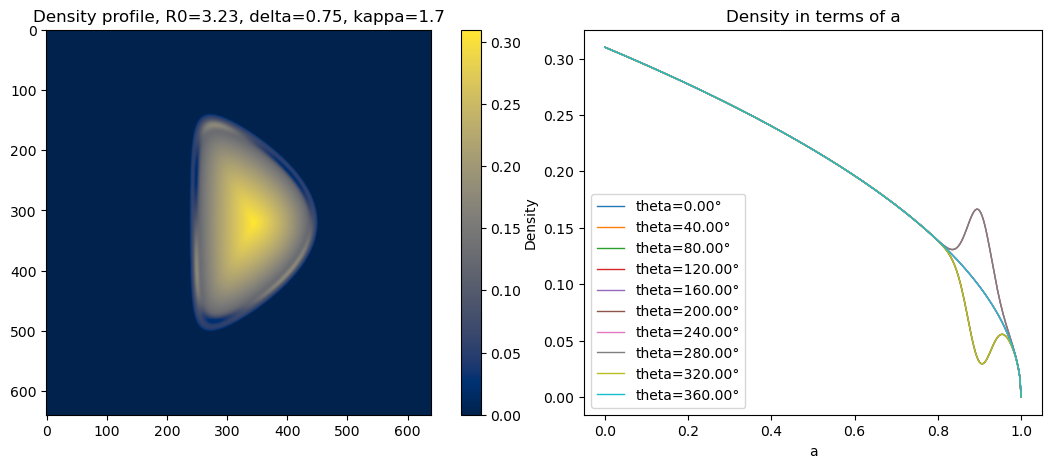

In [72]:
#create the plasma profile initially
if situation == 0:

    quartz=1 # quartz -> 0, 1 include quartz (1) or not (0)

    x2 = np.arange(0, 40*n_period, 1)

    X, Y = np.meshgrid(x2, x2)

    aux_jp = old_profile(X, Y, Nx, Ny, ne_peak, stdev, exponent, scale)
    
    
elif situation == 1:

    quartz=0

    x2 = np.arange(0, 40*n_period, 1)

    X, Y = np.meshgrid(x2, x2)

    aux_jp = profile(X, Y, Nx, Ny, ne_peak, eps, triang, scale)

elif situation == 2:

    quartz=0

    R = np.linspace(0, 6, 40*n_period)
    z = np.linspace(-3, 3, 40*n_period)

    aux_jp = make_density(R,z, R0, ne_peak, delta, kappa, jet_profile, amplitude, mode_num)

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    cont= ax[0].imshow(aux_jp, cmap='cividis')
    #ax[0].contour(aux_jp, 10, colors='black', linewidths=0.7)
    ax[0].set_aspect('equal')
    ax[0].set_title(f'Density profile, R0={R0}, delta={delta}, kappa={kappa}')
    divider_1 = make_axes_locatable(ax[0])
    cax = divider_1.append_axes("right", size="5%", pad=0.3)

    plt.colorbar(cont, cax=cax)
    
    angle = np.linspace(0.01, 2*np.pi, 200)
    R2, z2 = transform(angle, 1, R0, delta, kappa, scale)
    #ax[0].plot(R2*2, z2*2, color='black', linewidth=1)
    
    a_vals= np.linspace(0, 1, 300)
    thetas = np.linspace(0, 2*np.pi, 10)
    prof = np.array([[ne_peak*jet_profile(a, theta, amplitude, mode_num) for a in a_vals] for theta in thetas])
    for i in range(len(thetas)):
        ax[1].plot(a_vals, prof[i], linewidth=1, label=f'theta={(thetas[i]/np.pi*180):.2f}°')
    ax[1].set_xlabel('a')
    ax[1].set_ylabel('Density')
    ax[1].set_title('Density in terms of a')
    ax[1].legend()

    

"""------------------------------------------"""

make_B0(Nx, Ny, cntrl_para, B0)

quartz_tube(quartz, Nx, Ny, wavelength, n_period, EPSILON_R)

# omega_t = omega * t
omega_t = 0

In [73]:

# make circles to represent quartz tube
radius_1 = ((27 / 2) / wavelength) * n_period
radius_2 = ((30 / 2) / wavelength) * n_period

inner_radius = np.zeros((Nx, Ny))
outer_radius = np.zeros((Nx, Ny))
for x in range(Nx):
    for y in range(Ny):
        inner_radius[x, y] = (x - Nx / 2)**2 + (y - Ny / 2)**2 - radius_1**2
        outer_radius[x, y] = (x - Nx / 2)**2 + (y - Ny / 2)**2 - radius_2**2
        
        
# create a mock plasma profile      

plasma_radius = np.zeros((Nx, Ny))
for x in range(2, Nx - 2, 2):
    for y in range(2, Ny - 2, 2):
        #plasma_radius[x][y] = (x - x_max/2)**2 + (y - y_max/2)**2 - plasma_r**2
        plasma_radius[x, y] = ne_peak * np.exp(-(((x - Nx / 2)**2) / (2 * stdev**2) +  
                                                ((y - Ny / 2)**2) / (2 * stdev**2))**int(exponent))


In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def store_pictures(EE, BB, dens, n_period, Nx, Ny, situation, scale, counter):
    gs = gridspec.GridSpec(1, 3)

    plt.figure(figsize = (21, 6), dpi = 100)

    # power at receiving antenna
    ax1 = plt.subplot(gs[0, 2])
    ax1.plot(dens[3*n_period:-3*n_period:2])
    ax1.set_title('Power at receiving antenna', fontsize = 14)
    ax1.axvline(x = Nx/4-1.5*n_period, color = 'grey', linestyle = '--')
    ax1.set_ylabel('Power / AU')
    ax1.set_ylim(0,20)
    #ax1.legend(loc='upper right', fontsize=15)

    # contourf of |E|
    ax2 = plt.subplot(gs[0, 1])

    M = np.amax(np.abs(EE[::2, 1::2]))
    cf = ax2.contourf(EE[::2, 1::2], vmax=22.5, vmin=-22.5, levels=200, cmap=mymap, extend='max')
    ax2.set_title(r'E_y', fontsize = 14)
    ax2.set_aspect('equal')

    divider_1 = make_axes_locatable(ax2)
    cax = divider_1.append_axes("right", size="5%", pad=0.3)

    norm_1 = matplotlib.colors.Normalize(vmin=-22.5, vmax=22.5)
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm_1, cmap=mymap), cax=cax)

    ax3 = plt.subplot(gs[0, 0])
    px =  -EE[1::2, ::2] * BB[1::2, 1::2]
    py = EE[::2, 1::2] * BB[1::2, 1::2]
    power_dens = EE[::2, 1::2]**2 + BB[1::2, 1::2]**2
    Mx, mx = np.amax(px), np.amin(px)
    My, my = np.amax(py), np.amin(py)
    M3, m3 = np.amax(power_dens), np.amin(power_dens)
    cf_extra = ax3.contourf(py, vmax=500, vmin=-500, levels=200, cmap=mymap, extend='max')
    ax3.set_title(r'P_y', fontsize = 14)
    ax3.set_aspect('equal')

    divider_2 = make_axes_locatable(ax3)
    cax = divider_2.append_axes("right", size="5%", pad=0.3)
    norm = matplotlib.colors.Normalize(vmin=-500, vmax=500)
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=mymap), cax=cax)


    if situation == 0:
    # plot circles to represent the quartz tube
        ax2.contour(inner_radius[::2, ::2], levels = 0)
        ax2.contour(outer_radius[::2, ::2], levels = 0)
        ax3.contour(inner_radius[::2, ::2], levels = 0)
        ax3.contour(outer_radius[::2, ::2], levels = 0)
        
        cf1 = ax2.contour(plasma_radius[::2, ::2], levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
        cf2 = ax2.contour(plasma_radius[::2, ::2], levels=[.01], colors='white', linewidths=1)
        cf3 = ax3.contour(plasma_radius[::2, ::2], levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
        cf4 = ax3.contour(plasma_radius[::2, ::2], levels=[.01], colors='white', linewidths=1)

    elif situation == 1:

        x2 = np.arange(0, 20*n_period, 1)
        X, Y = np.meshgrid(x2, x2)

        ax2.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
        ax2.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=[.01], colors='white', linewidths=1)
        ax3.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=np.arange(0.1, 1, .1), colors='black', linewidths=1)
        ax3.contour(profile(X, Y, Nx/2, Ny/2, scale=scale/2, eps=eps, triang=triang), levels=[.01], colors='white', linewidths=1)

    elif situation == 2:

        ax2.contour(aux_jp[::2, ::2], levels=8, colors='black', linewidths=1)
        ax2.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
        ax3.contour(aux_jp[::2, ::2], levels=8, colors='black', linewidths=1)
        ax3.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)

    plt.savefig(f'99_files/shots/picture_{counter:03d}.png')
    plt.close()



In [75]:
%%time
%matplotlib inline

"""----------MAIN LOOP----------"""
counter=0

for t_int in range(0, t_end + 1):
    
    aux = t_int / 140
    
    t_rise = 1 - np.exp(-aux * aux)
    
    omega_t += 2 * np.pi * dt_1
    
    if (omega_t > 2 * np.pi):
        omega_t -= 2 * np.pi
    
    source = np.sin(omega_t) * t_rise / 1.4
    
    # excite magnetic field
    make_antenna_profile(Ny, xs, w0, source, BB)    
            
    # apply the absorbing boundary conditions
    absorbers(int(3 * n_period), Nx, Ny, EE, BB, JJ, B0)
    
    # update equations
    update_equations(Nx, Ny, dt, aux_jp, 
                     EE, BB, JJ, B0, EPSILON_R)
    
    # monitor power
    if t_int > t_power:
        
        power_receving_antenna(Ny, xr, EE, dens)
        #poynting_vector_Py(Ny, xr, EE, BB, dens)

    if t_int % 25 == 0:
        counter += 1
        store_pictures(EE, BB, dens, n_period, Nx, Ny, situation, scale, counter)

np.savetxt(f'{situation}_{scale}_{R0}_{delta}_{kappa}_{amplitude}_{mode_num}.txt', dens[3*n_period:-3*n_period:2])
print('Code finished successfuly') 

C:\Users\ewout\AppData\Local\Temp\ipykernel_11392\3620755467.py:74: UserWarning: No contour levels were found within the data range.
  ax2.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
C:\Users\ewout\AppData\Local\Temp\ipykernel_11392\3620755467.py:76: UserWarning: No contour levels were found within the data range.
  ax3.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
C:\Users\ewout\AppData\Local\Temp\ipykernel_11392\3620755467.py:74: UserWarning: No contour levels were found within the data range.
  ax2.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)
C:\Users\ewout\AppData\Local\Temp\ipykernel_11392\3620755467.py:76: UserWarning: No contour levels were found within the data range.
  ax3.contour(aux_jp[::2, ::2], levels=[0], colors='white', linewidths=1)


Code finished successfuly
CPU times: total: 1min 15s
Wall time: 2min 18s


## Plot results

In [76]:
import os

os.system("ffmpeg  -r 1/0.1 -i ./99_files/shots/picture_%3d.png -vb 20M -vcodec mpeg4 -y ./99_files/shots/evolution.mp4")

0